In [1]:
import numpy as np
import pandas as pd

#reading dataset
df96 = pd.read_csv('empirical_data/X_full.csv')
X = df96[df96.columns[1:]][:12*36]
df = pd.read_csv('empirical_data/Fama285.csv')
Y = df[df.columns[1:]]
#calculate sample mean and sample covariance matrix
mu = np.mean(X, axis=0)
Sigma = np.cov(X.T)
#solve the optimal MVE weight for all factors
wall = np.linalg.solve(Sigma, mu)
wall = wall / np.linalg.norm(wall)
idx = np.argsort(wall)[::-1]
#sort factors, from important for SR to less important
Ssort = idx[:96]
#select first 20 as initialization
St = idx[:20]


def sr(wt, mu, Sigma):
    return (np.dot(wt, mu) ** 2) / np.dot(np.dot(wt, Sigma), wt)

In [7]:
# temp =df96[["REG" , "MKTRF", "PEAD" , "HMLM" , "STR"  , "ILR1" , "SMB"  , "EPRD" , "BAB" ,  "BETA" ]] 
# temp =df96[['ILR1', 'SIM1', 'SMB', 'STR', 'REG', 'PEAD']][:12*36]
# temp =df96[['ILR1', 'SIM1', 'SMB', 'STR', 'REG', 'PEAD']]
temp = df96[['ILR1', 'MKTRF', 'HMLM', 'STR', 'REG', 'PEAD']]
w = np.linalg.inv(temp.cov())@temp.mean()
# w = w/w.sum()
ts_1 = temp@w
sr = ts_1.mean()/ts_1.std()
# sr = ts_1.mean()/ts_1.std()*np.sqrt(12)
sr**2

0.5438040172590718

In [3]:

# temp = df96[['REG','MKTRF','PEAD','HMLM','STR']]
temp = df96[['MKTRF', 'HMLM', 'STR', 'REG', 'PEAD']]
w = np.linalg.inv(temp.cov())@temp.mean()
# w = w/w.sum()
#w = w/np.linalg.norm(w)
ts_1 = temp@w
sr = ts_1.mean()/ts_1.std()*np.sqrt(12)
sr

2.41156220848919

In [141]:

#number of MH updates
T = 10000
#record the value of sharpe ratio + penalty in each MH update
SRwPenalty = np.zeros(T)
srsrsr = np.zeros(T)
#record the subset selection in each MH update
Sseq = np.zeros((96, T))
#An very important hyperparameter. Roughly speaking, if the variable can improve the SR by this value, then I can be selected.
# lambda_val = 0.06
lambda_val = 0.053
#If sigma is large, then the MH updates are more stable. 
sigma = 500

In [142]:

for t in range(T):
    #randomly select a variable to update
    i = np.random.randint(96)
    #update the new subset of selected variables
    Snew = np.setdiff1d(np.union1d(i, St), np.intersect1d(i, St))
    #find weight for MVE sharpe ratio w.r.t. St
  
    wt = np.linalg.solve(Sigma[St][:, St], mu[St])
    #find weight for MVE sharpe ratio w.r.t. Snew
    wnew = np.linalg.solve(Sigma[Snew][:, Snew], mu[Snew])
    #Find the "likelihood" ratio. If Snew gives larger SR than St or Snew has less factors than St, then this value will be large. 
    llhratio = np.exp(sigma * (sr(wnew, mu[Snew], Sigma[Snew][:, Snew]) - sr(wt, mu[St], Sigma[St][:, St]) - lambda_val * (len(Snew) - len(St))))
    #MH update. 
    random_num = np.random.rand()
    if llhratio > random_num:
        St = Snew
    #record the selected factors in Sseq
    Sseq[Snew, t] = 1
    #record Sharpe ratio + penalty
    SRwPenalty[t] = sr(wnew, mu[Snew], Sigma[Snew][:, Snew]) - lambda_val * len(Snew)
    srsrsr[t] = sr(wnew, mu[Snew], Sigma[Snew][:, Snew])

Selected factors: Index(['SIM1', 'STR', 'REG', 'PEAD'], dtype='object')
Sharpe ratio of the selected variables: 0.690149819774768
Sharpe ratio by greedy selection with the same size as our selection: 0.4256650132769457


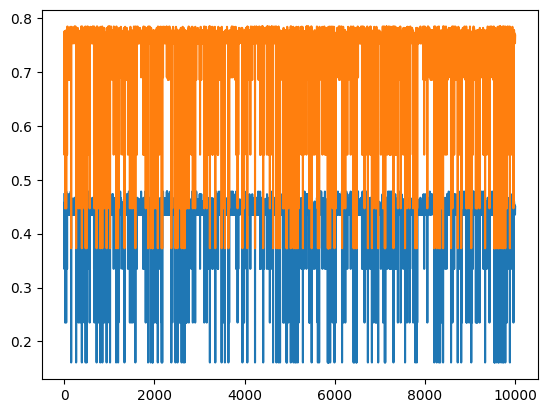

In [143]:
import matplotlib.pyplot as plt

#Plots
plt.plot(SRwPenalty)
plt.plot(srsrsr)
#plt.plot(np.sum(Sseq, axis=0))
#Find the index with largest value of Sharpe ratio + penalty
sridx = np.argmax(SRwPenalty)
#Find the indices of selected factors
Sopt = np.where(Sseq[:, sridx])[0]
#Find the weight corrsponding to Sopt
wSopt = np.linalg.solve(Sigma[Sopt][:, Sopt], mu[Sopt])
column_name = X.columns[Sopt]
print("Selected factors:", column_name)
print("Sharpe ratio of the selected variables:", sr(wSopt, mu[Sopt], Sigma[Sopt][:, Sopt]))
Ssort = idx[:len(Sopt)]
wB = np.linalg.solve(Sigma[Ssort][:, Ssort], mu[Ssort])
print("Sharpe ratio by greedy selection with the same size as our selection:", sr(wB, mu[Ssort], Sigma[Ssort][:, Ssort]))


In [ ]:
'''
Author: Naixin && naixinguo2-c@my.cityu.edu.hk
Date: 2023-09-06 22:48:49
LastEditors: Naixin && naixinguo2-c@my.cityu.edu.hk
LastEditTime: 2023-09-07 00:18:42
FilePath: /trylab/factor-ident/bayesian-rss.py
Description: 

'''
import numpy as np
import pandas as pd


#reading dataset
df96 = pd.read_csv('empirical_data/X_full.csv')
X = df96[df96.columns[1:]]
df = pd.read_csv('empirical_data/Fama285.csv')
Y = df[df.columns[1:]]
X = X / np.sqrt(np.sum(X**2, axis=0))
R = np.corrcoef(X.T)
idx = np.argsort(np.sum(np.abs(R), axis=0))[::-1]
St = idx[:20]
T = 1000
RSSwPenalty = np.zeros(T)
Sseq = np.zeros((96, T))
lambda_val = 15
sigma = 10

def RSS(X, Y, S):
    X_subset = X.iloc[:, S]
    X_array = X_subset.values
    Y_array = Y.values
    Xt = X_array.T
    XtX = np.dot(Xt, X_array)
    XtY = np.dot(Xt, Y_array)
    b = np.linalg.solve(XtX, XtY)
    Y_pred = X_subset@b
    residuals = Y_array - Y_pred
    rss = np.sum(np.sum(residuals**2))
    return rss

for t in range(T):
    i = np.random.randint(96)
    Snew = np.setdiff1d(np.union1d(i, St), np.intersect1d(i, St))
    llhratio = np.exp(-sigma * (RSS(X, Y, Snew) - RSS(X, Y, St) + lambda_val * (len(Snew) - len(St))))
    random_num = np.random.rand()
    if llhratio > random_num:
        St = Snew
    Sseq[Snew, t] = 1
    RSSwPenalty[t] = -RSS(X, Y, Snew) - lambda_val * len(Snew)

import matplotlib.pyplot as plt

plt.plot(RSSwPenalty)
plt.plot(np.sum(Sseq, axis=0))
sridx = np.argmax(RSSwPenalty)
Sopt = np.where(Sseq[:, sridx])[0]
column_name = X.columns[Sopt]
print("Selected factors:", column_name)
print("RSS of the selected variables:", RSS(X,Y,Sopt))
Ssort = idx[:len(Sopt)]
print("RSS by greedy selection with the same size as our selection:", RSS(X,Y,Ssort))

In [55]:
X.columns[Sopt]

Index(['ME', 'MKTRF', 'SMB', 'HML', 'UMD', 'STR', 'IVOL'], dtype='object')

In [ ]:
import numpy as np
import pandas as pd


#reading dataset
df96 = pd.read_csv('empirical_data/X_full.csv')
X = df96[df96.columns[1:]]
df = pd.read_csv('empirical_data/Fama285.csv')
Y = df[df.columns[1:]]

X = X / np.sqrt(np.sum(X**2, axis=0))
R = np.corrcoef(X.T)
idx = np.argsort(np.sum(np.abs(R), axis=0))[::-1]
St = idx[:20]
T = 1000
RSSwPenalty = np.zeros(T)
Sseq = np.zeros((96, T))
lambda_val = 1
sigma = 200

def alpha(X, Y, S):
    X_subset = X.iloc[:, S]
    X_array = np.hstack((np.ones(X_subset.shape[0])[:,np.newaxis],X_subset.values))
    Y_array = Y.values
    Xt = X_array.T
    XtX = np.dot(Xt, X_array)
    XtY = np.dot(Xt, Y_array)
    b = np.linalg.solve(XtX, XtY)
    Y_pred = X_array@b
    residuals = Y_array - Y_pred
    mean = np.mean(residuals, axis=0)
    std = np.std(residuals, axis=0)
    t_score =  mean / std 
    print(np.sum(np.abs(t_score)))
    # print(std.shape)
    std = np.sqrt(np.linalg.inv(XtX)[0][0]*sum(residuals**2 / (X_array.shape[0] - X_array.shape[1])))
    t_score =  mean / std 
   
    # mask = np.ones_like(t_score, dtype=bool)
    # mask[S] = False
    # abs_sum_t = np.sum(np.abs(t_score[mask]))
    abs_sum_t = np.sum(np.abs(t_score))
    print('2',abs_sum_t)
    return abs_sum_t

for t in range(T):
    i = np.random.randint(96)
    Snew = np.setdiff1d(np.union1d(i, St), np.intersect1d(i, St))
   
    llhratio = np.exp(sigma * (alpha(X, X, Snew) - alpha(X, X, St) - lambda_val * (len(Snew) - len(St))))
    random_num = np.random.rand()
    if llhratio > random_num:
        St = Snew
    Sseq[Snew, t] = 1
    RSSwPenalty[t] = alpha(X, X, Snew) + lambda_val * len(Snew)

import matplotlib.pyplot as plt

plt.plot(RSSwPenalty)
plt.plot(np.sum(Sseq, axis=0))
sridx = np.argmax(RSSwPenalty)
Sopt = np.where(Sseq[:, sridx])[0]
column_name = X.columns[Sopt]
print("Selected factors:", column_name)
print("sum of absolute t-score of the selected variables:", alpha(X,X,Sopt))
Ssort = idx[:len(Sopt)]
print("sum of absolute t-score of greedy selection with the same size as our selection:", alpha(X,X,Ssort))

In [ ]:
np.hstack((np.ones(X.shape[0]),X.values))

In [23]:
np.ones(X.shape[0])[:,np.newaxis].shape

(588, 1)

Selected factors: Index(['SMB', 'HML', 'HMLM', 'REG', 'IMD', 'PEAD'], dtype='object')
Sharpe ratio of the selected variables: 0.6705297105067073
Sharpe ratio by greedy selection with the same size as our selection: 0.625975600128677


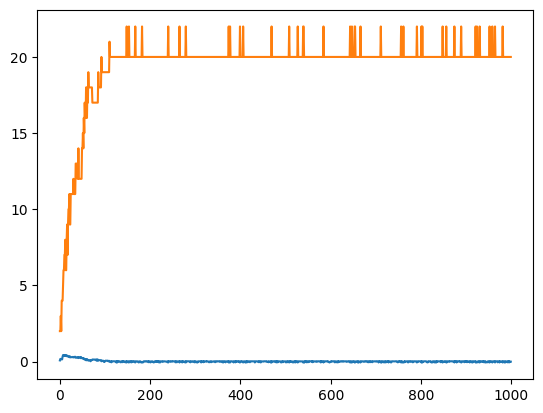

In [27]:
import numpy as np
import pandas as pd

#reading dataset
df96 = pd.read_csv('empirical_data/X_full_22.csv')
X = df96[df96.columns[1:]]
#calculate sample mean and sample covariance matrix
mu = np.mean(X, axis=0)
Sigma = np.cov(X.T)
#solve the optimal MVE weight for all factors
wall = np.linalg.solve(Sigma, mu)
wall = wall / np.linalg.norm(wall)
idx = np.argsort(wall)[::-1]
#sort factors, from important for SR to less important
Ssort = idx[:22]
#select first 20 as initialization
St = idx[:1]
#number of MH updates
T = 1000
#record the value of sharpe ratio + penalty in each MH update
SRwPenalty = np.zeros(T)
#record the subset selection in each MH update
Sseq = np.zeros((22, T))
#An very important hyperparameter. Roughly speaking, if the variable can improve the SR by this value, then I can be selected.
#lambda_val = 0.0327988
lambda_val = 0.04
#If sigma is large, then the MH updates are more stable. 
sigma = 200

#define the sharpe ratio
def sr(wt, mu, Sigma):
   
    return np.dot(wt, mu) / np.sqrt(np.dot(np.dot(wt, Sigma), wt))

for t in range(T):
    #randomly select a variable to update
    i = np.random.randint(22)
    #update the new subset of selected variables
    Snew = np.setdiff1d(np.union1d(i, St), np.intersect1d(i, St))
    #find weight for MVE sharpe ratio w.r.t. St
    wt = np.linalg.solve(Sigma[St][:, St], mu[St])
    #find weight for MVE sharpe ratio w.r.t. Snew
    wnew = np.linalg.solve(Sigma[Snew][:, Snew], mu[Snew])
    #Find the "likelihood" ratio. If Snew gives larger SR than St or Snew has less factors than St, then this value will be large. 
    # llhratio = np.exp(sigma * (sr(wnew, mu[Snew], Sigma[Snew][:, Snew]) - sr(wt, mu[St], Sigma[St][:, St]) - lambda_val * (len(Snew) - len(St))))
    #MH update. 
    random_num = np.random.rand()
 
    if len(Snew)<22 and (X.shape[0]-X.shape[1])/(X.shape[1] - len(Snew))* ((1+sr(np.linalg.solve(Sigma, mu), mu, Sigma)**2)/(1+sr(wnew, mu[Snew], Sigma[Snew][:, Snew])**2)-1)< (X.shape[0]-X.shape[1])/(X.shape[1] - len(St))* ((1+sr(np.linalg.solve(Sigma, mu), mu, Sigma)**2)/(1+sr(wt, mu[St], Sigma[St][:, St])**2)-1):
        St = Snew
    # if llhratio > random_num:
        # St = Snew
    #record the selected factors in Sseq
    Sseq[Snew, t] = 1
    #record Sharpe ratio + penalty
    SRwPenalty[t] = sr(wnew, mu[Snew], Sigma[Snew][:, Snew]) - lambda_val * len(Snew)

import matplotlib.pyplot as plt

#Plots
plt.plot(SRwPenalty)
plt.plot(np.sum(Sseq, axis=0))
#Find the index with largest value of Sharpe ratio + penalty
sridx = np.argmax(SRwPenalty)
#Find the indices of selected factors
Sopt = np.where(Sseq[:, sridx])[0]
#Find the weight corrsponding to Sopt
wSopt = np.linalg.solve(Sigma[Sopt][:, Sopt], mu[Sopt])
column_name = X.columns[Sopt]
print("Selected factors:", column_name)
print("Sharpe ratio of the selected variables:", sr(wSopt, mu[Sopt], Sigma[Sopt][:, Sopt]))
Ssort = idx[:len(Sopt)]
wB = np.linalg.solve(Sigma[Ssort][:, Ssort], mu[Ssort])
print("Sharpe ratio by greedy selection with the same size as our selection:", sr(wB, mu[Ssort], Sigma[Ssort][:, Ssort]))



In [103]:
wSopt = np.linalg.solve(Sigma[np.where(np.isin(mu.index,['SMB', 'MKTRF', 'HMLM', 'STR', 'REG', 'PEAD','QMJ','UMD']))[0]][:,np.where(np.isin(mu.index,['SMB', 'MKTRF', 'HMLM', 'STR', 'REG', 'PEAD','QMJ','UMD']))[0]], mu[np.where(np.isin(mu.index,['SMB', 'MKTRF', 'HMLM', 'STR', 'REG', 'PEAD','QMJ','UMD']))[0]])

sr(wSopt, mu[np.where(np.isin(mu.index,['SMB', 'MKTRF', 'HMLM', 'STR', 'REG', 'PEAD','QMJ','UMD']))[0]], Sigma[np.where(np.isin(mu.index,['SMB', 'MKTRF', 'HMLM', 'STR', 'REG', 'PEAD','QMJ','UMD']))[0]][:, np.where(np.isin(mu.index,['SMB', 'MKTRF', 'HMLM', 'STR', 'REG', 'PEAD','QMJ','UMD']))[0]])

0.7466178370245051

In [48]:
sr(wSopt, mu[Sopt], Sigma[Sopt][:, Sopt])

0.4846360237844384

In [348]:
temp = df96[['SMB', 'MKTRF', 'HMLM', 'STR', 'REG', 'PEAD','QMJ','UMD']]
# temp = df96[['ILR1', 'MKTRF', 'HMLM', 'STR', 'REG', 'PEAD']]
w = np.linalg.inv(temp.cov())@temp.mean()
# w = w/w.sum()
ts_1 = temp@w
sr = ts_1.mean()/ts_1.std()*np.sqrt(12)
sr

2.586360055127245

In [8]:
import numpy as np
import pandas as pd
from helpers import *
N_chosen_set = []
for i in range(1,101):
    #reading dataset
    N=600
    k2=100
    k1=5
    df = pd.read_csv('./simu_matrix/'+str(N)+'_'+str(k2)+'_'+str(k1)+'Xfull'+str(i)+'.csv')
    X = df[df.columns[1:]]
    
    # Z, M, B = create_factors(3000, 5, 25+1, sig=0.1)
    # # redefine Z to be all the other columns except the last one
    # X= Z[:, :-1]
    
    #calculate sample mean and sample covariance matrix
    mu = np.mean(X, axis=0)
    Sigma = np.cov(X.T)
    #solve the optimal MVE weight for all factors
    wall = np.linalg.solve(Sigma, mu)
    wall = wall / np.linalg.norm(wall)
    idx = np.argsort(wall)[::-1]
    #sort factors, from important for SR to less important
    Ssort = idx[:k1+k2]
    #select first 20 as initialization
    St = idx[:20]
    #number of MH updates
    T = 10000
    #record the value of sharpe ratio + penalty in each MH update
    SRwPenalty = np.zeros(T)
    #record the subset selection in each MH update
    Sseq = np.zeros((k1+k2, T))
    #An very important hyperparameter. Roughly speaking, if the variable can improve the SR by this value, then I can be selected.
    #lambda_val = 0.0327988
    # lambda_val = 0.0034
    # #If sigma is large, then the MH updates are more stable. 
    # sigma = 200
    #0.005
    lambda_val = 0.01
    #If sigma is large, then the MH updates are more stable. 
    sigma = 300
    #define the sharpe ratio
    def sr(wt, mu, Sigma):
        wt = wt/ sum(wt)
        return  (np.dot(wt, mu))**2/ np.dot(np.dot(wt, Sigma), wt)
    for t in range(T):
        #randomly select a variable to update
        i = np.random.randint(k1+k2)
        #update the new subset of selected variables
        Snew = np.setdiff1d(np.union1d(i, St), np.intersect1d(i, St))
        
        #find weight for MVE sharpe ratio w.r.t. St
        wt = np.linalg.solve(Sigma[St][:, St], mu[St])
       
        #find weight for MVE sharpe ratio w.r.t. Snew
        wnew = np.linalg.solve(Sigma[Snew][:, Snew], mu[Snew])
     
        #Find the "likelihood" ratio. If Snew gives larger SR than St or Snew has less factors than St, then this value will be large. 
        # llhratio = np.exp(sigma * (sr(wnew, mu[Snew], Sigma[Snew][:, Snew]) - sr(wt, mu[St], Sigma[St][:, St]) - lambda_val * (len(Snew) - len(St))))
        llhratio = np.exp(sigma * (sr(wnew, mu[Snew], Sigma[Snew][:, Snew]) - sr(wt, mu[St], Sigma[St][:, St]) - lambda_val * (len(Snew) - len(St))))
        
        # llhratio = np.exp(sigma * (sr(wnew, mu[Snew], Sigma[Snew][:, Snew]) - sr(wt, mu[St], Sigma[St][:, St]) ))
        #MH update. 
        random_num = np.random.rand()
        # if (X.shape[0]-X.shape[1])/(X.shape[1] - len(wnew))* ((1+sr(np.linalg.solve(Sigma, mu), mu, Sigma)**2)/(1+sr(wnew, mu[Snew], Sigma[Snew][:, Snew])**2)-1)< (X.shape[0]-X.shape[1])/(X.shape[1] - len(wt))* ((1+sr(np.linalg.solve(Sigma, mu), mu, Sigma)**2)/(1+sr(wt, mu[St], Sigma[St][:, St])**2)-1):
        #     St = Snew
        if min(1,llhratio) >= random_num:
           St = Snew
        # print(t,St)
        #record the selected factors in Sseq
        Sseq[Snew, t] = 1
        #record Sharpe ratio + penalty
        SRwPenalty[t] = sr(wnew, mu[Snew], Sigma[Snew][:, Snew]) - lambda_val * len(Snew)
    # print(sigma * (sr(wnew, mu[Snew], Sigma[Snew][:, Snew]) - sr(wt, mu[St], Sigma[St][:, St])))
    sridx = np.argmax(SRwPenalty)
    #Find the indices of selected factors
    Sopt = np.where(Sseq[:, sridx])[0]
    #Find the weight corrsponding to Sopt
    print('Sopt',Sopt)
    s12345=[0,1,2,3,4]
    print(max(SRwPenalty),'[01234]',sr(np.linalg.solve(Sigma[s12345][:, s12345], mu[s12345]), mu[s12345], Sigma[s12345][:, s12345]) - lambda_val *5)
    print(sr(np.linalg.solve(Sigma[Sopt][:, Sopt], mu[Sopt]),mu[Sopt], Sigma[Sopt][:, Sopt]) ,'[01234]',sr(np.linalg.solve(Sigma[s12345][:, s12345], mu[s12345]), mu[s12345], Sigma[s12345][:, s12345]))

    wSopt = np.linalg.solve(Sigma[Sopt][:, Sopt], mu[Sopt])
    # print("Sharpe ratio of the selected variables:", sr(wSopt, mu[Sopt], Sigma[Sopt][:, Sopt]))
    N_chosen_set.append(list(Sopt))
    
    
num_chosen_set=[]
Final_knum=[]
for unionset in N_chosen_set:
   num_chosen_set.append(unionset) 
   Final_knum.append(len(unionset))
    
evaluate(num_chosen_set,100) #3/5



Sopt [  0   1   2   4 101]
0.09458579687556633 [01234] 0.09897350388125735
0.14458579687556633 [01234] 0.14897350388125735
Sopt [ 0  1  2  3  4 14 45 62 73 92]
0.17262016574027703 [01234] 0.18306181673109956
0.27262016574027703 [01234] 0.23306181673109955
Sopt [  0   1   2   3  40  47  60  87 100]
0.08342273133211761 [01234] 0.08467017196015099
0.1734227313321176 [01234] 0.134670171960151
Sopt [  0   2   3   4  29  55  67  70  78  98 100]
0.1312147087085198 [01234] 0.13043555899204745
0.2412147087085198 [01234] 0.18043555899204747
Sopt [ 0  1  2  3  4  8 14 30 36 38 60]
0.1434355639284277 [01234] 0.15103908206727673
0.2534355639284277 [01234] 0.20103908206727672
Sopt [ 0  1  2  3  4 17]
0.09845411040265772 [01234] 0.10352586209856506
0.15845411040265772 [01234] 0.15352586209856506
Sopt [  0   1   2  11  19  45  48  59  64  65 101]
0.11287523813751756 [01234] 0.12306188677304176
0.22287523813751756 [01234] 0.17306188677304177
Sopt [ 0  1  2  3  4 34 51]
0.11381329720105207 [01234] 0.119

(8.59, 0.42, 0.01, 0.858, 0.095, 0.837154)

In [38]:
def sr(wt, mu, Sigma):
    return  np.abs(np.dot(wt, mu))/ np.sqrt(np.dot(np.dot(wt, Sigma), wt))
sr(np.linalg.solve(Sigma[s12345][:, s12345], mu[s12345]), mu[s12345], Sigma[s12345][:, s12345])

0.29828797102193244

In [43]:
print(max(SRwPenalty),'[01234]',sr(np.linalg.solve(Sigma[s12345][:, s12345], mu[s12345]), mu[s12345], Sigma[s12345][:, s12345]) - lambda_val *5)

0.351332813411889 [01234] 0.35408930101919106


In [203]:
num_chosen_set=[]
Final_knum=[]
for unionset in N_chosen_set:
   num_chosen_set.append(list(unionset) )
   Final_knum.append(len(unionset))
    
evaluate(num_chosen_set,100) #3/5


Counter({0: 100, 4: 98, 3: 91, 1: 57, 2: 27, 13: 10, 19: 10, 22: 9, 24: 9, 16: 8, 20: 8, 7: 8, 21: 8, 8: 8, 15: 8, 23: 7, 14: 6, 11: 6, 12: 6, 18: 5, 5: 5, 9: 4, 10: 3, 17: 3, 6: 3})
selected factor size: 5.07 CP: 0.14 CF: 0.08 TR: 0.746 FR: 0.134 F1: 0.744998


(5.07, 0.14, 0.08, 0.746, 0.134, 0.744998)

In [336]:
wall = np.linalg.solve(Sigma, mu)
wall = wall / np.linalg.norm(wall)
idx = np.argsort(wall)[::-1]
idx

array([ 4,  3,  0,  1,  2,  9, 22,  5,  6, 21, 23, 17, 14,  8, 18, 24, 20,
        7, 15, 10, 16, 12, 13, 19, 11])